try to understand libFM from this [script](http://nbviewer.jupyter.org/github/jfpuget/LibFM_in_Keras/blob/master/keras_blog.ipynb)

and use it in this competition

In [45]:
import keras 
import pandas as pd
import numpy as np
import gc


In [46]:
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dot, Reshape, Add, Subtract
from keras import objectives
from keras import backend as K
from keras import regularizers 
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

In [47]:
import scipy.sparse as sp

In [48]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os

def init_seeds(seed):
    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)
    return sess

In [49]:
k_latent = 2
embedding_reg = 0.0002
kernel_reg = 0.1

def get_embed(x_input, x_size, k_latent):
    if x_size > 0: #category
        embed = Embedding(x_size, k_latent, input_length=1, 
                          embeddings_regularizer=l2(embedding_reg))(x_input)
        embed = Flatten()(embed)
    else:
        embed = Dense(k_latent, kernel_regularizer=l2(embedding_reg))(x_input)
    return embed

def build_model_1(X, f_size):
    dim_input = len(f_size)
    
    input_x = [Input(shape=(1,)) for i in range(dim_input)] 
     
    biases = [get_embed(x, size, 1) for (x, size) in zip(input_x, f_size)]
    
    factors = [get_embed(x, size, k_latent) for (x, size) in zip(input_x, f_size)]
    
    s = Add()(factors)
    
    diffs = [Subtract()([s, x]) for x in factors]
    
    dots = [Dot(axes=1)([d, x]) for d,x in zip(diffs, factors)]
    
    x = Concatenate()(biases + dots)
    x = BatchNormalization()(x)
    output = Dense(1, activation='relu', kernel_regularizer=l2(kernel_reg))(x)
    model = Model(inputs=input_x, outputs=[output])
    opt = Adam(clipnorm=0.5)
    model.compile(optimizer=opt, loss='mean_squared_error')
    output_f = factors + biases
    model_features = Model(inputs=input_x, outputs=output_f)
    return model, model_features

In [5]:
%%time 
df_train = pd.read_pickle('../input/train.pkl')

Wall time: 4.89 s


encode uidx, iidx

In [50]:
def get_df_matrix_mappings(df, row_name, col_name):
    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid


    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid


    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid

In [7]:
print('build id->idx map ...')
rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = get_df_matrix_mappings(df_train,'user_id','item_seq_number')


df_trn_uidx = pd.DataFrame()
df_trn_uidx['uidx']= df_train.user_id.map(rid_to_idx)
df_trn_uidx['iidx']= df_train.item_seq_number.map(cid_to_idx)
df_trn_uidx['uid'] = df_train.user_id
df_trn_uidx['iid'] = df_train.item_seq_number

print('build iidx, uidx col')
df_train['iidx'] = df_train.item_seq_number.map(cid_to_idx).astype('uint16')
df_train['uidx'] = df_train.user_id.map(rid_to_idx).astype('uint32')

build id->idx map ...
build iidx, uidx col


encode city_region 

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
def create_label_encoding_with_min_count(df, column, min_count=50):
    column_counts = df.groupby([column])[column].transform("count").astype(int)
    column_values = np.where(column_counts >= min_count, df[column], "")
    df[column+"_label"] = LabelEncoder().fit_transform(column_values)
    
    return df[column+"_label"]

In [10]:
df_train['region_city2'] = df_train.groupby(['region','city'])['region'].transform(lambda x:np.random.random()) ## faster and encode it correctly!!
df_train['region_city2_label'] = create_label_encoding_with_min_count(df_train,'region_city2',min_count=50)

df_train.drop('region_city2',axis=1,inplace=True)

In [34]:
# sel_cols = ['uidx','iidx','']
feats = ['uidx','iidx']#,'region_city2_label','image_top_1']

target = ['deal_probability']
fm_data = df_train[feats].copy()
fm_data.head()

,uidx,iidx
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


In [35]:
fm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 2 columns):
uidx    1503424 non-null uint32
iidx    1503424 non-null uint16
dtypes: uint16(1), uint32(1)
memory usage: 8.6 MB


In [38]:
# print('max val image_top_1',fm_data.image_top_1.max())
# fm_data['image_top_1'] = fm_data.image_top_1.fillna(3067).astype('uint16')


In [39]:
f_size  = [int(fm_data[f].max()) + 1 for f in feats]
f_size

[771769, 26079]

In [40]:
fm_data.dtypes

uidx    uint32
iidx    uint16
dtype: object

In [41]:
fm_data = fm_data.merge(df_train[['uidx','iidx','deal_probability']], how='left',on=['uidx','iidx'])

In [42]:
fm_data.head()

,uidx,iidx,deal_probability
0,0,0,0.12789
1,1,1,0.00000
2,2,2,0.43177
3,3,3,0.80323
4,4,4,0.20797


build fm 

In [43]:
X_train = [fm_data[f].values for f in feats]
y_train = (fm_data['deal_probability'].values).astype('float32')

In [51]:
model, model_features = build_model_1(X_train, f_size)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 2)         1543538     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 2)         52158       input_2[0][0]                    
__________________________________________________________________________________________________
flatten_3 

In [52]:
model_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 2)         1543538     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 2)         52158       input_2[0][0]                    
__________________________________________________________________________________________________
embedding_

In [53]:
fm_data.shape

(1503424, 3)

In [54]:
2**12

4096

In [55]:
n_epochs = 100
P = 12
try:
    del sess
except:
    pass
sess = init_seeds(0)

batch_size = 2**P
print(batch_size)
model, model_features = build_model_1(X_train, f_size)
earlystopper = EarlyStopping(patience=0, verbose=1)

model.fit(X_train,  y_train, 
          epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=True, 
          validation_data=(X_train, y_train), 
#           sample_weight=w_train,
          callbacks=[earlystopper],
         )

4096
Train on 1503424 samples, validate on 1503424 samples
Epoch 1/100
1503424/1503424 [==============================] - 92s 61us/step - loss: 0.2147 - val_loss: 0.1268
Epoch 2/100
1503424/1503424 [==============================] - 88s 59us/step - loss: 0.1052 - val_loss: 0.0803
Epoch 3/100
1503424/1503424 [==============================] - 89s 59us/step - loss: 0.0775 - val_loss: 0.0650
Epoch 4/100
1503424/1503424 [==============================] - 89s 59us/step - loss: 0.0707 - val_loss: 0.0616
Epoch 5/100
1503424/1503424 [==============================] - 89s 59us/step - loss: 0.0700 - val_loss: 0.0602
Epoch 6/100
1503424/1503424 [==============================] - 89s 59us/step - loss: 0.0699 - val_loss: 0.0591
Epoch 7/100
1503424/1503424 [==============================] - 90s 60us/step - loss: 0.0694 - val_loss: 0.0579
Epoch 8/100
1503424/1503424 [==============================] - 89s 59us/step - loss: 0.0687 - val_loss: 0.0569
Epoch 9/100
1503424/1503424 [========================

In [56]:
result = model.predict(X_train,batch_size=batch_size)

In [64]:
X_pred = model_features.predict(X_train, batch_size=batch_size)

In [95]:
# X_pred[:len(feats)]

In [65]:
feats

['uidx', 'iidx']

In [66]:
factors = X_pred[:len(feats)]

biases = X_pred[len(feats):2*len(feats)]

for f, X_p in zip(feats, factors):
    for i in range(k_latent):
        fm_data['%s_fm_factor_%d' % (f, i)] = X_p[:,i]

for f, X_p in zip(feats, biases):
    fm_data['%s_fm_bias' % (f)] = X_p[:,0]

fm_data.head()

,uidx,iidx,deal_probability,uidx_fm_factor_0,uidx_fm_factor_1,iidx_fm_factor_0,iidx_fm_factor_1,uidx_fm_bias,iidx_fm_bias
0,0,0,0.12789,5.814371e-32,-4.188051e-34,-8.275533e-33,1.139949e-32,0.000006,0.087593
1,1,1,0.00000,5.575870e-32,5.708553e-34,4.006117e-33,4.041425e-33,0.019104,0.038058
2,2,2,0.43177,-2.221814e-32,-1.801257e-32,8.551332e-34,-8.390112e-33,-0.004823,0.051516
3,3,3,0.80323,1.341696e-32,2.741651e-32,2.416178e-32,-4.123943e-34,-0.025035,0.000412
4,4,4,0.20797,6.549448e-32,2.223676e-32,7.815027e-33,1.294836e-32,-0.000040,0.081084


In [123]:
# used_cols = ['deal_probability','uidx_fm_bias','iidx_fm_bias','region_city2_label_fm_bias','image_top_1_fm_bias']
# fm_data[used_cols].corr()

,deal_probability,uidx_fm_bias,iidx_fm_bias,region_city2_label_fm_bias,image_top_1_fm_bias
deal_probability,1.000000,-0.643092,-0.116859,-0.011302,-0.330248
uidx_fm_bias,-0.643092,1.000000,0.086963,0.005518,-0.015974
iidx_fm_bias,-0.116859,0.086963,1.000000,-0.101912,0.140643
region_city2_label_fm_bias,-0.011302,0.005518,-0.101912,1.000000,-0.062619
image_top_1_fm_bias,-0.330248,-0.015974,0.140643,-0.062619,1.000000


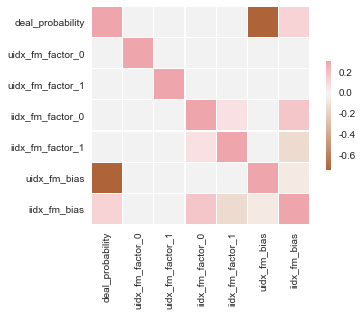

In [81]:
import seaborn as sns
%matplotlib inline
selcols = [e for e in list(fm_data.columns) if e not in feats]
corr = fm_data[selcols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

cmap = sns.diverging_palette(30,10,as_cmap=True)
sns.heatmap(corr,cmap=cmap,center=0,square=True,vmax=.3,linewidths=.1, cbar_kws={"shrink": .5});

seems factor is useless (almost zeros)... 

In [83]:
fm_data.head()

,uidx,iidx,deal_probability,uidx_fm_factor_0,uidx_fm_factor_1,iidx_fm_factor_0,iidx_fm_factor_1,uidx_fm_bias,iidx_fm_bias
0,0,0,0.12789,5.814371e-32,-4.188051e-34,-8.275533e-33,1.139949e-32,0.000006,0.087593
1,1,1,0.00000,5.575870e-32,5.708553e-34,4.006117e-33,4.041425e-33,0.019104,0.038058
2,2,2,0.43177,-2.221814e-32,-1.801257e-32,8.551332e-34,-8.390112e-33,-0.004823,0.051516
3,3,3,0.80323,1.341696e-32,2.741651e-32,2.416178e-32,-4.123943e-34,-0.025035,0.000412
4,4,4,0.20797,6.549448e-32,2.223676e-32,7.815027e-33,1.294836e-32,-0.000040,0.081084


In [86]:
fm_data.drop(['uidx','iidx','deal_probability'],axis=1,
             inplace=True)

In [90]:
fm_data.columns

Index(['uidx_fm_factor_0', 'uidx_fm_factor_1', 'iidx_fm_factor_0',
       'iidx_fm_factor_1', 'uidx_fm_bias', 'iidx_fm_bias'],
      dtype='object')

In [92]:
fm_data.drop(['uidx_fm_factor_0','uidx_fm_factor_1','iidx_fm_factor_0','iidx_fm_factor_1'],
             axis=1,
             inplace=True)

In [93]:
fm_data.head()

,uidx_fm_bias,iidx_fm_bias
0,0.000006,0.087593
1,0.019104,0.038058
2,-0.004823,0.051516
3,-0.025035,0.000412
4,-0.000040,0.081084


In [94]:
store = pd.HDFStore('../input/feats/trn_fm_1.h5')
store['trn_fm_bias'] = fm_data
store.close()

_____

not train on deal_prob directly

but some sort of groupby count

In [122]:
feats = ['uidx','region_city2_label']
fm_data = df_train.groupby(feats).size().reset_index().rename(columns={0:'cnt'})

In [123]:
fm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785453 entries, 0 to 785452
Data columns (total 3 columns):
uidx                  785453 non-null uint64
region_city2_label    785453 non-null int64
cnt                   785453 non-null int64
dtypes: int64(2), uint64(1)
memory usage: 18.0 MB


In [120]:
# print('max val image_top_1',fm_data.image_top_1.max())
# fm_data['image_top_1'] = fm_data.image_top_1.fillna(3067).astype('uint16')


In [124]:
f_size  = [int(fm_data[f].max()) + 1 for f in feats]
f_size

[771769, 677]

In [125]:
fm_data.dtypes

uidx                  uint64
region_city2_label     int64
cnt                    int64
dtype: object

In [126]:
# fm_data['deal_probability'] = df_train.deal_probability

build fm 

In [129]:
X_train = [fm_data[f].values for f in feats]
y_train = (fm_data['cnt'].values).astype('float32')

In [130]:
fm_data.shape

(785453, 3)

In [ ]:
n_epochs = 100
P = 12
try:
    del sess
except:
    pass
sess = init_seeds(0)

batch_size = 2**P
print(batch_size)
model, model_features = build_model_1(X_train, f_size)
earlystopper = EarlyStopping(patience=0, verbose=1)

model.fit(X_train,  y_train, 
          epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=True, 
          validation_data=(X_train, y_train), 
#           sample_weight=w_train,
          callbacks=[earlystopper],
         )

4096
Train on 785453 samples, validate on 785453 samples
Epoch 1/100
785453/785453 [==============================] - 49s 63us/step - loss: 25.0881 - val_loss: 24.2573
Epoch 2/100
785453/785453 [==============================] - 45s 57us/step - loss: 24.0262 - val_loss: 23.3229
Epoch 3/100
785453/785453 [==============================] - 45s 57us/step - loss: 22.8154 - val_loss: 21.8780
Epoch 4/100
785453/785453 [==============================] - 45s 58us/step - loss: 21.1258 - val_loss: 20.3382
Epoch 5/100
785453/785453 [==============================] - 45s 57us/step - loss: 19.9795 - val_loss: 19.3580
Epoch 6/100
785453/785453 [==============================] - 45s 57us/step - loss: 19.2256 - val_loss: 18.4469
Epoch 7/100
785453/785453 [==============================] - 45s 57us/step - loss: 18.3334 - val_loss: 17.7309
Epoch 8/100
785453/785453 [==============================] - 45s 58us/step - loss: 17.6376 - val_loss: 16.8413
Epoch 9/100
785453/785453 [============================

In [64]:
X_pred = model_features.predict(X_train, batch_size=batch_size)

In [56]:
# result = model.predict(X_train,batch_size=batch_size)

In [65]:
feats

['uidx', 'iidx']

In [66]:
factors = X_pred[:len(feats)]

biases = X_pred[len(feats):2*len(feats)]

for f, X_p in zip(feats, factors):
    for i in range(k_latent):
        fm_data['%s_fm_factor_%d' % (f, i)] = X_p[:,i]

for f, X_p in zip(feats, biases):
    fm_data['%s_fm_bias' % (f)] = X_p[:,0]

fm_data.head()

,uidx,iidx,deal_probability,uidx_fm_factor_0,uidx_fm_factor_1,iidx_fm_factor_0,iidx_fm_factor_1,uidx_fm_bias,iidx_fm_bias
0,0,0,0.12789,5.814371e-32,-4.188051e-34,-8.275533e-33,1.139949e-32,0.000006,0.087593
1,1,1,0.00000,5.575870e-32,5.708553e-34,4.006117e-33,4.041425e-33,0.019104,0.038058
2,2,2,0.43177,-2.221814e-32,-1.801257e-32,8.551332e-34,-8.390112e-33,-0.004823,0.051516
3,3,3,0.80323,1.341696e-32,2.741651e-32,2.416178e-32,-4.123943e-34,-0.025035,0.000412
4,4,4,0.20797,6.549448e-32,2.223676e-32,7.815027e-33,1.294836e-32,-0.000040,0.081084
